In [1]:
import torch
import causal_improved_sudormrf_v3 
import soundfile as sf
from os.path import join as pjoin
import time as t
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.set_num_threads(1)

In [3]:
mps_device = torch.device('cpu')

In [4]:
def load_sudormrf_causal_cpu(model_path, device):
    # 1: declarem el model (instanciem la classe)
    model = causal_improved_sudormrf_v3.CausalSuDORMRF(
        in_audio_channels=1,
        out_channels=512,
        in_channels=256,
        num_blocks=16,
        upsampling_depth=5,
        enc_kernel_size=21,
        enc_num_basis=512,
        num_sources=1,
        )
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.module.to(device)
    model.eval()
    return model

In [5]:
fs = 16000

In [6]:
model = load_sudormrf_causal_cpu('e39_sudo_whamr_16k_enhnoisy_augment.pt', mps_device)

In [7]:
#now load 5s mixture

In [14]:
mixture, fs = sf.read('16k_mixture.wav')

In [15]:
mixture = torch.tensor(mixture, dtype=torch.float32)

In [16]:
mixture = mixture[:16000*5]

In [17]:
audio_length = len(mixture) / fs

In [18]:
audio_length

5.0

In [13]:
len(mixture)

87360

In [13]:
# test how performance degrades when using short chunks

In [31]:
num_chunks = [20] #latència de 250ms

In [32]:
times = []
sisdrs = []
chunk_sizes = []
minitimes = []
for chunks in tqdm.tqdm(num_chunks):
    #try:
    if chunks == 1:
        mix_list = [mixture]
    else:
        # split into simple chunks (rectangular window and no overlap), dropping the last one
        mix_list = torch.split(mixture, len(mixture) // chunks)#[0:-1]
    chunk_sizes.append(len(mix_list[0]))
    #targets_list = torch.split(targets, len(mixture) // chunks, dim=1)[0:-1]
    # compute the audio
    rec_sources = []
    tic = t.time()
    for m in mix_list:
        tic2 = t.time()
        rec_sources.append(model(m.unsqueeze(0).unsqueeze(1)).squeeze())
        tac2 = t.time()
        minitimes.append(tac2 - tic2)
    #rec_sources = torch.cat(rec_sources, dim=1)
    #sisdrs.append(loss(rec_sources.unsqueeze(0), targets[:, :rec_sources.shape[1]].unsqueeze(0)).item())
    tac = t.time()
    times.append(tac - tic)
    '''
    except:
        times.append('nan')
        #sisdrs.append('nan')
        chunk_sizes.append('nan')
    ''';

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


In [33]:
# necessitem 4.7 segons per processar 5s
times

[4.696674108505249]

In [35]:
# cada frame de 0.25s necessita...
minitimes

[0.22901582717895508,
 0.23395800590515137,
 0.24158906936645508,
 0.2427358627319336,
 0.23684287071228027,
 0.23272204399108887,
 0.23292183876037598,
 0.2315211296081543,
 0.23326897621154785,
 0.23348093032836914,
 0.23163604736328125,
 0.23152494430541992,
 0.2347428798675537,
 0.23444724082946777,
 0.23223090171813965,
 0.23607993125915527,
 0.23505306243896484,
 0.23535990715026855,
 0.23633289337158203,
 0.24112725257873535]

In [25]:
ms_sizes = [x*1000 / fs for x in chunk_sizes]

In [26]:
results = {'times' : times, 'ms_sizes' : ms_sizes}

In [28]:
len(mixture)/fs

5.46

In [29]:
realtime_factor = [x/(len(mixture)/fs) for x in times]

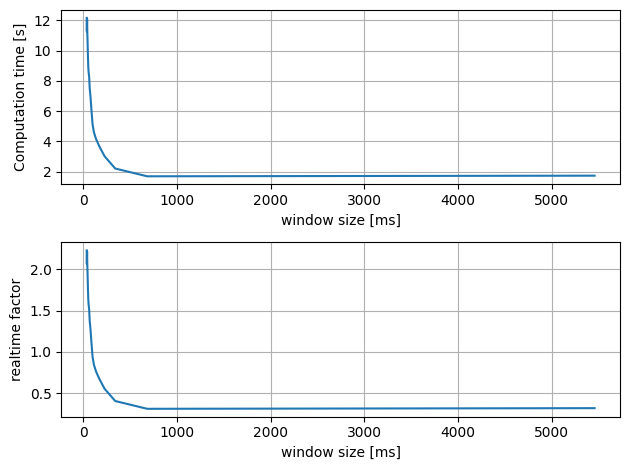

In [33]:
plt.subplot(2,1,1)
plt.plot(ms_sizes, times)
plt.ylabel('Computation time [s]')
plt.xlabel('window size [ms]')
plt.tight_layout()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(ms_sizes, realtime_factor)
plt.ylabel('realtime factor')
plt.xlabel('window size [ms]')
plt.tight_layout()
plt.grid(True)

In [ ]:
# in my desktop, 16000samples windows should be enough. 
# in this laptop we see we'll need at least 250ms windows, which means 4000 samples